In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import gensim

from gensim.models import Word2Vec, KeyedVectors

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import re
import matplotlib.pyplot as plt
import nltk

from tensorflow.keras.utils import to_categorical

In [2]:
data = pd.read_csv("data/news_class.csv")

df = data.copy() # to be safe and avoid errors

df = df.loc[:,["data_id" , "content" , "category_level_1" , "category_level_2"]]
df.groupby(['category_level_1'])['data_id'].agg('count')

category_level_1
arts, culture, entertainment and media        300
conflict, war and peace                       800
crime, law and justice                        500
disaster, accident and emergency incident     500
economy, business and finance                 400
education                                     607
environment                                   600
health                                        700
human interest                                600
labour                                        703
lifestyle and leisure                         300
politics                                      900
religion and belief                           800
science and technology                        800
society                                      1100
sport                                         907
weather                                       400
Name: data_id, dtype: int64

In [3]:
def labeler(dataframe_column):
    encoder=LabelEncoder()
    
    labels = encoder.fit_transform(dataframe_column)
    print(encoder.classes_)
    print("We did it boys , labels have been created")
    
    return(pd.DataFrame(labels))

In [4]:
# Function for removing ASCII characters
def _removeNonAscii(s):
    return "".join(i for i in s if  ord(i)<128)

# Function for converting to lower case
def make_lower_case(text):
    return text.lower()

# Function for removing stop words
def remove_stop_words(text):
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

# Function for removing html
def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

# Function for removing punctuation
def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text

def lemm_text(text):
    lemm=WordNetLemmatizer()
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    tokens = text
    return ' '.join([lemm.lemmatize(t) for t in tokens])

In [5]:
df['Cleaned'] = df['content'].apply(_removeNonAscii)
df['Cleaned'] = df.Cleaned.apply(func = make_lower_case)
df['Cleaned'] = df.Cleaned.apply(func = remove_stop_words)
df['Cleaned'] = df.Cleaned.apply(func = remove_punctuation)
df['Cleaned'] = df.Cleaned.apply(func = remove_html)
df['Cleaned'] = df.Cleaned.apply(func = lemm_text)
df = df.drop('content' , axis =1)

In [6]:
io = df.copy()

io = io.drop([374]).reset_index(drop=True)
io = io.drop([6527]).reset_index(drop=True)

corpus_full = []
for words in io['Cleaned']:
    corpus_full.append(words.split())  

In [7]:
def vectorizer():
    
    
    # Creating a list for storing the vectors ('Description' into vectors)
    #global word_embeddings
    word_embeddings = []
    i = 0
    # Reading the each 'Description'
    for line in io['Cleaned']:
        avgword2vec = None
        count = 0
        for word in line.split():
            if word in model.wv.key_to_index:
                count += 1
                if avgword2vec is None:
                    avgword2vec = model.wv[word]
                else:
                    avgword2vec = avgword2vec + model.wv[word]
                
        if avgword2vec is not None:
            avgword2vec = avgword2vec / count
            word_embeddings.append(avgword2vec)
        else:
            print("I found it , the error occurs at line:" , i)
          
        i +=1 

    return(pd.DataFrame(word_embeddings))  # Returning our Data as a Dataframe (aesthetic reasons)

In [98]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [8]:
model = Word2Vec.load("word2vec.model3")

In [9]:
vect = vectorizer()

In [10]:
y1 = labeler(io["category_level_1"])


X = vect.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y1, test_size=0.2,random_state=42)

y_train1 = to_categorical(y_train)


['arts, culture, entertainment and media' 'conflict, war and peace'
 'crime, law and justice' 'disaster, accident and emergency incident'
 'economy, business and finance' 'education' 'environment' 'health'
 'human interest' 'labour' 'lifestyle and leisure' 'politics'
 'religion and belief' 'science and technology' 'society' 'sport'
 'weather']
We did it boys , labels have been created


In [22]:
xpX_train = np.expand_dims(X_train, -1)
xpX_test = np.expand_dims(X_test, -1)

In [11]:
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import Flatten , Input , Conv2D , MaxPooling2D , BatchNormalization

In [42]:
model_rnn = Sequential()
model_rnn.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True), input_shape=(xpX_train.shape[1], xpX_train.shape[2])))
model_rnn.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))) 
model_rnn.add(tf.keras.layers.Dense(17,activation='softmax'))

In [43]:
model_rnn.compile(optimizer='adam', 
          loss = 'categorical_crossentropy',
          metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])

In [44]:
model_rnn.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_12 (Bidirect  (None, 200, 128)          33792     
 ional)                                                          
                                                                 
 bidirectional_13 (Bidirect  (None, 64)                41216     
 ional)                                                          
                                                                 
 dense_6 (Dense)             (None, 17)                1105      
                                                                 
Total params: 76113 (297.32 KB)
Trainable params: 76113 (297.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [27]:
X_train.shape , xpX_train.shape

((8732, 200), (8732, 200, 1))

In [28]:
model_rnn.fit(xpX_train, y_train1, batch_size = 16 ,epochs=2, validation_split=(0.2) ,verbose =1)

Epoch 1/2

437/437 [==============================] - 45s 88ms/step - loss: 2.6179 - accuracy: 0.9412 - val_loss: 2.4113 - val_accuracy: 0.9425
Epoch 2/2
437/437 [==============================] - 38s 88ms/step - loss: 2.1420 - accuracy: 0.9428 - val_loss: 1.9361 - val_accuracy: 0.9447


In [29]:
predictions = np.argmax(model_rnn.predict(X_test), axis=-1)

print(classification_report(y_test.values , predictions))

69/69 [==============================] - 4s 33ms/step
              precision    recall  f1-score   support

           0       0.20      0.03      0.05        68
           1       0.40      0.56      0.47       176
           2       0.39      0.25      0.30        97
           3       0.50      0.47      0.48        90
           4       0.26      0.16      0.20        93
           5       0.37      0.24      0.29       108
           6       0.42      0.38      0.40       126
           7       0.37      0.42      0.39       136
           8       0.27      0.26      0.26       122
           9       0.36      0.11      0.17       155
          10       1.00      0.07      0.12        61
          11       0.25      0.32      0.28       172
          12       0.38      0.64      0.48       182
          13       0.34      0.28      0.31       151
          14       0.22      0.18      0.20       200
          15       0.43      0.84      0.57       169
          16       0.79    

In [30]:
predictions

array([15, 12,  3, ..., 12, 14,  1], dtype=int64)

In [45]:
for i in range(100):
    
    print( "At iteration , we rastarted the RNN BIDERECTIONAL NETWORK"  ,i , " we get these data :" )
    
    model_rnn.fit(xpX_train, y_train1, batch_size = 16 ,epochs=1, validation_split=(0.2) ,verbose =1)

    predictions = np.argmax(model_rnn.predict(xpX_test), axis=-1)

    print(classification_report(y_test.values , predictions))

At iteration , we rastarted the RNN BIDERECTIONAL NETWORK 0  we get these data :
69/69 [==============================] - 4s 37ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        68
           1       0.13      0.12      0.13       176
           2       0.00      0.00      0.00        97
           3       0.47      0.19      0.27        90
           4       0.00      0.00      0.00        93
           5       0.00      0.00      0.00       108
           6       0.00      0.00      0.00       126
           7       0.17      0.69      0.27       136
           8       0.00      0.00      0.00       122
           9       0.00      0.00      0.00       155
          10       0.00      0.00      0.00        61
          11       0.00      0.00      0.00       172
          12       0.00      0.00      0.00       182
          13       0.16      0.06      0.09       151
          14       0.11      0.69      0.19       200


C:\Users\Desktop\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Desktop\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Desktop\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


69/69 [==============================] - 2s 32ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        68
           1       0.45      0.55      0.49       176
           2       0.43      0.03      0.06        97
           3       0.41      0.52      0.46        90
           4       0.33      0.01      0.02        93
           5       0.29      0.33      0.31       108
           6       0.14      0.11      0.12       126
           7       0.36      0.13      0.19       136
           8       0.33      0.10      0.15       122
           9       0.43      0.06      0.10       155
          10       0.50      0.03      0.06        61
          11       0.29      0.56      0.38       172
          12       0.50      0.17      0.25       182
          13       0.21      0.66      0.32       151
          14       0.13      0.30      0.19       200
          15       0.69      0.52      0.59       169
          16       0.84    

C:\Users\Desktop\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Desktop\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Desktop\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


69/69 [==============================] - 2s 33ms/step
              precision    recall  f1-score   support

           0       0.10      0.03      0.04        68
           1       0.48      0.61      0.54       176
           2       0.32      0.07      0.12        97
           3       0.50      0.48      0.49        90
           4       1.00      0.01      0.02        93
           5       0.25      0.45      0.32       108
           6       0.30      0.20      0.24       126
           7       0.26      0.24      0.25       136
           8       0.33      0.13      0.19       122
           9       0.31      0.12      0.18       155
          10       0.28      0.64      0.39        61
          11       0.35      0.41      0.38       172
          12       0.63      0.36      0.46       182
          13       0.23      0.58      0.33       151
          14       0.15      0.14      0.15       200
          15       0.53      0.79      0.63       169
          16       0.90    

C:\Users\Desktop\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Desktop\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Desktop\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


69/69 [==============================] - 2s 33ms/step
              precision    recall  f1-score   support

           0       1.00      0.01      0.03        68
           1       0.48      0.52      0.50       176
           2       0.59      0.13      0.22        97
           3       0.34      0.57      0.42        90
           4       0.40      0.02      0.04        93
           5       0.34      0.23      0.27       108
           6       0.29      0.35      0.32       126
           7       0.38      0.36      0.37       136
           8       0.30      0.34      0.32       122
           9       0.65      0.13      0.22       155
          10       0.38      0.48      0.42        61
          11       0.32      0.48      0.38       172
          12       0.38      0.65      0.48       182
          13       0.27      0.36      0.31       151
          14       0.23      0.17      0.20       200
          15       0.66      0.78      0.71       169
          16       0.71    

69/69 [==============================] - 2s 33ms/step
              precision    recall  f1-score   support

           0       0.67      0.06      0.11        68
           1       0.63      0.69      0.66       176
           2       0.54      0.51      0.52        97
           3       0.53      0.56      0.54        90
           4       0.40      0.40      0.40        93
           5       0.45      0.35      0.39       108
           6       0.58      0.44      0.50       126
           7       0.52      0.54      0.53       136
           8       0.39      0.33      0.36       122
           9       0.53      0.31      0.39       155
          10       0.52      0.56      0.54        61
          11       0.39      0.53      0.45       172
          12       0.62      0.73      0.67       182
          13       0.42      0.54      0.47       151
          14       0.32      0.33      0.32       200
          15       0.67      0.79      0.72       169
          16       0.78    

69/69 [==============================] - 2s 33ms/step
              precision    recall  f1-score   support

           0       0.38      0.34      0.36        68
           1       0.71      0.47      0.56       176
           2       0.57      0.67      0.61        97
           3       0.58      0.49      0.53        90
           4       0.76      0.17      0.28        93
           5       0.42      0.50      0.45       108
           6       0.64      0.57      0.61       126
           7       0.52      0.51      0.52       136
           8       0.59      0.11      0.18       122
           9       0.76      0.38      0.51       155
          10       0.67      0.30      0.41        61
          11       0.33      0.70      0.44       172
          12       0.54      0.80      0.64       182
          13       0.44      0.46      0.45       151
          14       0.38      0.29      0.33       200
          15       0.64      0.89      0.74       169
          16       0.67    

69/69 [==============================] - 2s 33ms/step
              precision    recall  f1-score   support

           0       0.45      0.35      0.40        68
           1       0.75      0.56      0.64       176
           2       0.49      0.69      0.57        97
           3       0.66      0.52      0.58        90
           4       0.84      0.39      0.53        93
           5       0.58      0.62      0.60       108
           6       0.73      0.61      0.67       126
           7       0.66      0.52      0.58       136
           8       0.49      0.35      0.41       122
           9       0.64      0.63      0.64       155
          10       0.59      0.57      0.58        61
          11       0.46      0.59      0.52       172
          12       0.67      0.71      0.69       182
          13       0.46      0.62      0.53       151
          14       0.38      0.46      0.42       200
          15       0.76      0.82      0.79       169
          16       0.81    

69/69 [==============================] - 2s 33ms/step
              precision    recall  f1-score   support

           0       0.32      0.32      0.32        68
           1       0.71      0.67      0.69       176
           2       0.56      0.66      0.61        97
           3       0.60      0.61      0.60        90
           4       0.66      0.47      0.55        93
           5       0.61      0.58      0.59       108
           6       0.62      0.75      0.68       126
           7       0.64      0.54      0.59       136
           8       0.53      0.38      0.44       122
           9       0.67      0.54      0.60       155
          10       0.42      0.62      0.50        61
          11       0.50      0.57      0.53       172
          12       0.66      0.74      0.70       182
          13       0.53      0.58      0.56       151
          14       0.42      0.38      0.40       200
          15       0.75      0.77      0.76       169
          16       0.78    

69/69 [==============================] - 2s 33ms/step
              precision    recall  f1-score   support

           0       0.38      0.35      0.36        68
           1       0.68      0.73      0.70       176
           2       0.52      0.60      0.56        97
           3       0.57      0.62      0.59        90
           4       0.64      0.52      0.57        93
           5       0.60      0.69      0.64       108
           6       0.71      0.73      0.72       126
           7       0.66      0.59      0.62       136
           8       0.58      0.45      0.51       122
           9       0.65      0.54      0.59       155
          10       0.54      0.62      0.58        61
          11       0.50      0.52      0.51       172
          12       0.80      0.65      0.72       182
          13       0.55      0.58      0.57       151
          14       0.46      0.46      0.46       200
          15       0.68      0.84      0.75       169
          16       0.83    

69/69 [==============================] - 2s 35ms/step
              precision    recall  f1-score   support

           0       0.43      0.43      0.43        68
           1       0.72      0.69      0.71       176
           2       0.65      0.45      0.53        97
           3       0.59      0.58      0.58        90
           4       0.68      0.47      0.56        93
           5       0.50      0.75      0.60       108
           6       0.70      0.72      0.71       126
           7       0.60      0.69      0.64       136
           8       0.62      0.41      0.50       122
           9       0.63      0.58      0.60       155
          10       0.63      0.54      0.58        61
          11       0.51      0.60      0.56       172
          12       0.74      0.69      0.71       182
          13       0.69      0.48      0.56       151
          14       0.43      0.48      0.46       200
          15       0.72      0.89      0.80       169
          16       0.77    

KeyboardInterrupt: 

# MOdeL bidirectional 2 + More dense layers

In [63]:
model_rnn_2 = Sequential()
model_rnn_2.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(120, return_sequences=True), input_shape=(xpX_train.shape[1], xpX_train.shape[2])))
model_rnn_2.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(60)))
model_rnn_2.add(tf.keras.layers.Dense(60,activation='leaky_relu'))
model_rnn_2.add(tf.keras.layers.Dense(30,activation='leaky_relu'))
model_rnn_2.add(tf.keras.layers.Dense(20,activation='leaky_relu'))
model_rnn_2.add(tf.keras.layers.Dense(17,activation='softmax'))

In [75]:
model_rnn_2.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_26 (Bidirect  (None, 200, 240)          117120    
 ional)                                                          
                                                                 
 bidirectional_27 (Bidirect  (None, 120)               144480    
 ional)                                                          
                                                                 
 dense_28 (Dense)            (None, 60)                7260      
                                                                 
 dense_29 (Dense)            (None, 30)                1830      
                                                                 
 dense_30 (Dense)            (None, 20)                620       
                                                                 
 dense_31 (Dense)            (None, 17)              

In [64]:
opt = tf.keras.optimizers.AdamW(learning_rate =0.0005 , beta_1=0.9,
    beta_2=0.999,
    use_ema=True,
    ema_momentum=0.99)

model_rnn_2.compile(optimizer=opt, 
          loss = 'categorical_crossentropy',
          metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])

In [65]:
from sklearn.metrics import f1_score, precision_score, recall_score

In [59]:
for i in range(10):
    
    print( "At iteration , we rastarted the RNN BIDERECTIONAL NETWORK"  ,i , " we get these data :" )
    
    model_rnn_2.fit(xpX_train, y_train1, batch_size = 16 ,epochs=1, validation_split=(0.1) ,verbose =1)

    predictions = np.argmax(model_rnn_2.predict(xpX_test), axis=-1)
    print(predictions)
    
    if i >= 5:
        #if precision_score(y_test.values, predictions, average='macro') >= 0.52:
        print(classification_report(y_test.values , predictions))
        print('Precision is {}'.format(precision_score(y_test.values, predictions, average='macro')))
        print("Poutsara mou kati kanoume twra sthn " , i  , "epanalispsi , thelei ligo parapanw sos")

At iteration , we rastarted the RNN BIDERECTIONAL NETWORK 0  we get these data :
69/69 [==============================] - 6s 59ms/step
[14 14 14 ... 14 14 14]
At iteration , we rastarted the RNN BIDERECTIONAL NETWORK 1  we get these data :
69/69 [==============================] - 4s 62ms/step
[14 14 14 ... 14 14 14]
At iteration , we rastarted the RNN BIDERECTIONAL NETWORK 2  we get these data :
69/69 [==============================] - 4s 58ms/step
[14 14 14 ... 14 14 14]
At iteration , we rastarted the RNN BIDERECTIONAL NETWORK 3  we get these data :
69/69 [==============================] - 4s 60ms/step
[14 14 14 ... 11 14 14]
At iteration , we rastarted the RNN BIDERECTIONAL NETWORK 4  we get these data :
69/69 [==============================] - 4s 63ms/step
[14 14 14 ... 12 14 14]
At iteration , we rastarted the RNN BIDERECTIONAL NETWORK 5  we get these data :
69/69 [==============================] - 4s 60ms/step
[14 14 11 ... 11 14 12]
At iteration , we rastarted the RNN BIDERECTIO

C:\Users\Desktop\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


69/69 [==============================] - 4s 60ms/step
[14 14 14 ... 11 14 15]
At iteration , we rastarted the RNN BIDERECTIONAL NETWORK 7  we get these data :
  1/492 [..............................] - ETA: 56s - loss: 2.7512 - accuracy: 0.9412

C:\Users\Desktop\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 66/492 [===>..........................] - ETA: 51s - loss: 2.4009 - accuracy: 0.9425

KeyboardInterrupt: 

# RNN MODEL 3

In [109]:
model_rnn3 = Sequential()
model_rnn3.add(tf.keras.layers.GRU(units=60, return_sequences=True, input_shape=(xpX_train.shape[1],xpX_train.shape[2]), activation='tanh'))
model_rnn3.add(tf.keras.layers.Dropout(0.2))
model_rnn3.add(tf.keras.layers.GRU(units=30 , activation='tanh'))
model_rnn3.add(tf.keras.layers.Dense(17,activation='softmax'))

In [110]:
model_rnn3.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_19 (GRU)                (None, 200, 60)           11340     
                                                                 
 dropout_13 (Dropout)        (None, 200, 60)           0         
                                                                 
 gru_20 (GRU)                (None, 30)                8280      
                                                                 
 dense_48 (Dense)            (None, 17)                527       
                                                                 
Total params: 20147 (78.70 KB)
Trainable params: 20147 (78.70 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [111]:
opt = tf.keras.optimizers.AdamW(learning_rate =0.0005 , beta_1=0.9,
    beta_2=0.999,
    use_ema=True,
    ema_momentum=0.99)

model_rnn3.compile(optimizer=opt, 
          loss = 'categorical_crossentropy',
          metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])

In [112]:
""" for i in range(10):
    
    print( "At iteration , we rastarted the RNN BIDERECTIONAL NETWORK"  ,i , " we get these data :" )
    
    model_rnn3.fit(xpX_train, y_train1, batch_size = 16 ,epochs=1, validation_split=(0.1) ,verbose =1)

    predictions = np.argmax(model_rnn3.predict(xpX_test), axis=-1)
    print(predictions)
    
    if i >= 5:
        #if precision_score(y_test.values, predictions, average='macro') >= 0.52:
        print(classification_report(y_test.values , predictions))
        print('Precision is {}'.format(precision_score(y_test.values, predictions, average='macro')))
        print("Poutsara mou kati kanoume twra sthn " , i  , "epanalispsi , thelei ligo parapanw sos")
        
""" 

' for i in range(10):\n    \n    print( "At iteration , we rastarted the RNN BIDERECTIONAL NETWORK"  ,i , " we get these data :" )\n    \n    model_rnn3.fit(xpX_train, y_train1, batch_size = 16 ,epochs=1, validation_split=(0.1) ,verbose =1)\n\n    predictions = np.argmax(model_rnn3.predict(xpX_test), axis=-1)\n    print(predictions)\n    \n    if i >= 5:\n        #if precision_score(y_test.values, predictions, average=\'macro\') >= 0.52:\n        print(classification_report(y_test.values , predictions))\n        print(\'Precision is {}\'.format(precision_score(y_test.values, predictions, average=\'macro\')))\n        print("Poutsara mou kati kanoume twra sthn " , i  , "epanalispsi , thelei ligo parapanw sos")\n        \n'

In [113]:
history = model_rnn3.fit(xpX_train, y_train1, batch_size = 16 ,epochs=10, validation_split=(0.1) ,verbose =1) # 10 epan

Epoch 1/10
492/492 [==============================] - 47s 87ms/step - loss: 2.7804 - accuracy: 0.9412 - val_loss: 2.7476 - val_accuracy: 0.9412
Epoch 2/10
492/492 [==============================] - 41s 83ms/step - loss: 2.5929 - accuracy: 0.9412 - val_loss: 2.5117 - val_accuracy: 0.9412
Epoch 3/10
492/492 [==============================] - 43s 87ms/step - loss: 2.4620 - accuracy: 0.9412 - val_loss: 2.4379 - val_accuracy: 0.9412
Epoch 4/10
492/492 [==============================] - 41s 83ms/step - loss: 2.3814 - accuracy: 0.9412 - val_loss: 2.4170 - val_accuracy: 0.9418
Epoch 5/10
492/492 [==============================] - 42s 85ms/step - loss: 2.3084 - accuracy: 0.9418 - val_loss: 2.2791 - val_accuracy: 0.9418
Epoch 6/10
492/492 [==============================] - 42s 85ms/step - loss: 2.2355 - accuracy: 0.9419 - val_loss: 2.1886 - val_accuracy: 0.9423
Epoch 7/10
492/492 [==============================] - 42s 84ms/step - loss: 2.1920 - accuracy: 0.9421 - val_loss: 2.2062 - val_accuracy:

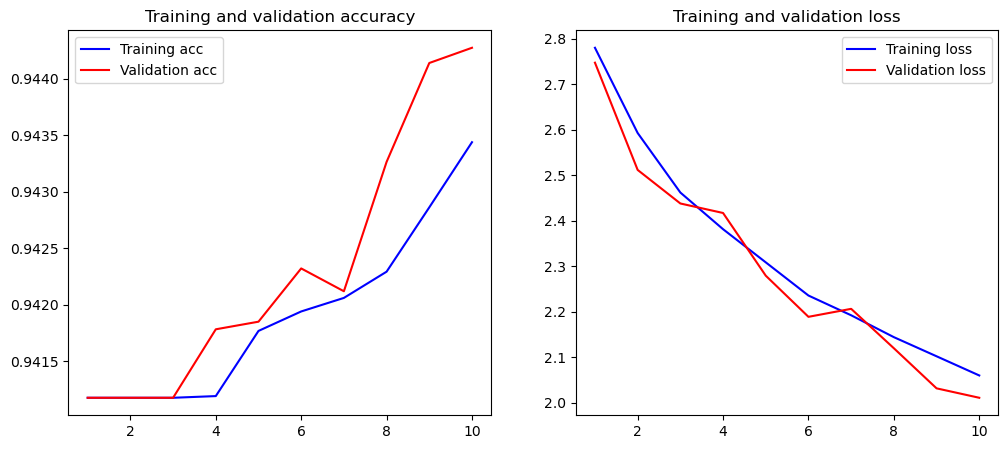

In [114]:
plot_history(history)

In [115]:
predictions = np.argmax(model_rnn3.predict(xpX_test), axis=-1)
print(predictions)

print(classification_report(y_test.values , predictions))
print('Precision is {}'.format(precision_score(y_test.values, predictions, average='macro')))
print("Poutsara mou kati kanoume twra sthn " , i  , "epanalispsi , thelei ligo parapanw sos")

69/69 [==============================] - 3s 28ms/step
[15 12 16 ...  1 14 12]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        68
           1       0.37      0.39      0.38       176
           2       1.00      0.01      0.02        97
           3       0.59      0.49      0.53        90
           4       1.00      0.01      0.02        93
           5       0.29      0.22      0.25       108
           6       0.33      0.31      0.32       126
           7       0.39      0.34      0.36       136
           8       0.56      0.15      0.23       122
           9       0.12      0.01      0.02       155
          10       0.39      0.49      0.43        61
          11       0.24      0.51      0.33       172
          12       0.43      0.62      0.51       182
          13       0.24      0.28      0.26       151
          14       0.15      0.21      0.18       200
          15       0.42      0.73      0.53       169
   

C:\Users\Desktop\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Desktop\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Desktop\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Desktop\anaconda3\Lib\site-packages\skle

In [116]:
history = model_rnn3.fit(xpX_train, y_train1, batch_size = 16 ,epochs=10, validation_split=(0.1) ,verbose =1) # 20 epan

Epoch 1/10
492/492 [==============================] - 41s 84ms/step - loss: 2.0134 - accuracy: 0.9439 - val_loss: 1.9546 - val_accuracy: 0.9451
Epoch 2/10
492/492 [==============================] - 43s 88ms/step - loss: 1.9695 - accuracy: 0.9445 - val_loss: 1.9345 - val_accuracy: 0.9460
Epoch 3/10
492/492 [==============================] - 46s 94ms/step - loss: 1.9306 - accuracy: 0.9454 - val_loss: 1.8798 - val_accuracy: 0.9456
Epoch 4/10
492/492 [==============================] - 41s 82ms/step - loss: 1.8897 - accuracy: 0.9458 - val_loss: 1.8545 - val_accuracy: 0.9471
Epoch 5/10
492/492 [==============================] - 42s 85ms/step - loss: 1.8673 - accuracy: 0.9460 - val_loss: 1.8208 - val_accuracy: 0.9471
Epoch 6/10
492/492 [==============================] - 46s 94ms/step - loss: 1.8358 - accuracy: 0.9463 - val_loss: 1.8011 - val_accuracy: 0.9479
Epoch 7/10
492/492 [==============================] - 52s 105ms/step - loss: 1.8130 - accuracy: 0.9466 - val_loss: 1.7750 - val_accuracy

69/69 [==============================] - 2s 35ms/step
[14  1 16 ...  1  9 12]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        68
           1       0.59      0.66      0.62       176
           2       0.43      0.36      0.39        97
           3       0.60      0.59      0.60        90
           4       0.34      0.15      0.21        93
           5       0.38      0.44      0.41       108
           6       0.48      0.46      0.47       126
           7       0.48      0.50      0.49       136
           8       0.34      0.21      0.26       122
           9       0.46      0.35      0.40       155
          10       0.42      0.51      0.46        61
          11       0.37      0.46      0.41       172
          12       0.55      0.64      0.59       182
          13       0.37      0.47      0.41       151
          14       0.19      0.20      0.20       200
          15       0.61      0.73      0.67       169
   

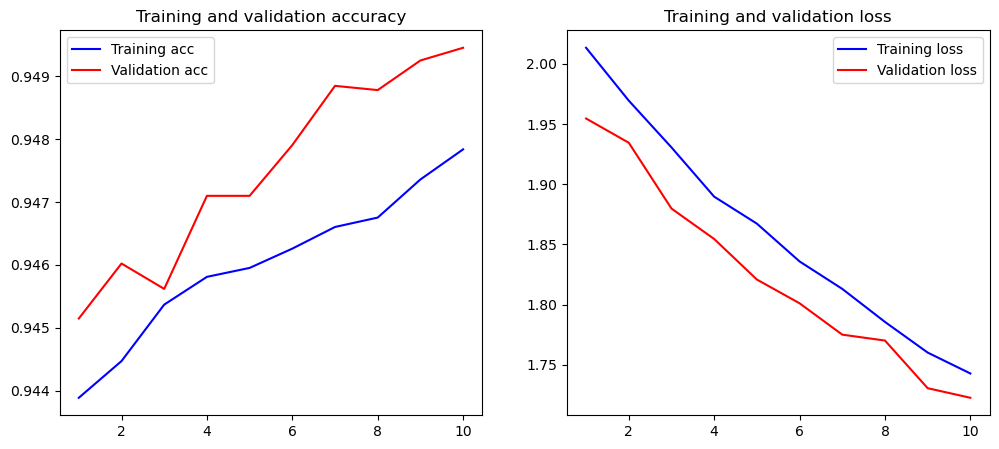

In [117]:
plot_history(history)

predictions = np.argmax(model_rnn3.predict(xpX_test), axis=-1)
print(predictions)

print(classification_report(y_test.values , predictions))
print('Precision is {}'.format(precision_score(y_test.values, predictions, average='macro')))
print("Poutsara mou kati kanoume twra sthn " , i  , "epanalispsi , thelei ligo parapanw sos")

In [118]:
history = model_rnn3.fit(xpX_train, y_train1, batch_size = 16 ,epochs=10, validation_split=(0.1) ,verbose =1) # 30 epan

Epoch 1/10
492/492 [==============================] - 49s 100ms/step - loss: 1.7204 - accuracy: 0.9481 - val_loss: 1.7606 - val_accuracy: 0.9484
Epoch 2/10
492/492 [==============================] - 43s 88ms/step - loss: 1.7038 - accuracy: 0.9481 - val_loss: 1.7396 - val_accuracy: 0.9486
Epoch 3/10
492/492 [==============================] - 44s 90ms/step - loss: 1.6847 - accuracy: 0.9484 - val_loss: 1.6930 - val_accuracy: 0.9499
Epoch 4/10
492/492 [==============================] - 44s 90ms/step - loss: 1.6581 - accuracy: 0.9488 - val_loss: 1.6905 - val_accuracy: 0.9508
Epoch 5/10
492/492 [==============================] - 43s 88ms/step - loss: 1.6538 - accuracy: 0.9493 - val_loss: 1.6457 - val_accuracy: 0.9507
Epoch 6/10
492/492 [==============================] - 43s 88ms/step - loss: 1.6289 - accuracy: 0.9495 - val_loss: 1.6293 - val_accuracy: 0.9512
Epoch 7/10
492/492 [==============================] - 44s 90ms/step - loss: 1.6108 - accuracy: 0.9498 - val_loss: 1.6366 - val_accuracy

69/69 [==============================] - 2s 35ms/step
[14  1 16 ... 11  9 12]
              precision    recall  f1-score   support

           0       0.15      0.03      0.05        68
           1       0.63      0.73      0.68       176
           2       0.51      0.55      0.53        97
           3       0.62      0.56      0.59        90
           4       0.49      0.24      0.32        93
           5       0.42      0.56      0.48       108
           6       0.54      0.70      0.61       126
           7       0.54      0.57      0.56       136
           8       0.40      0.22      0.28       122
           9       0.52      0.42      0.47       155
          10       0.38      0.43      0.40        61
          11       0.41      0.48      0.45       172
          12       0.54      0.66      0.59       182
          13       0.50      0.54      0.52       151
          14       0.24      0.18      0.21       200
          15       0.65      0.75      0.69       169
   

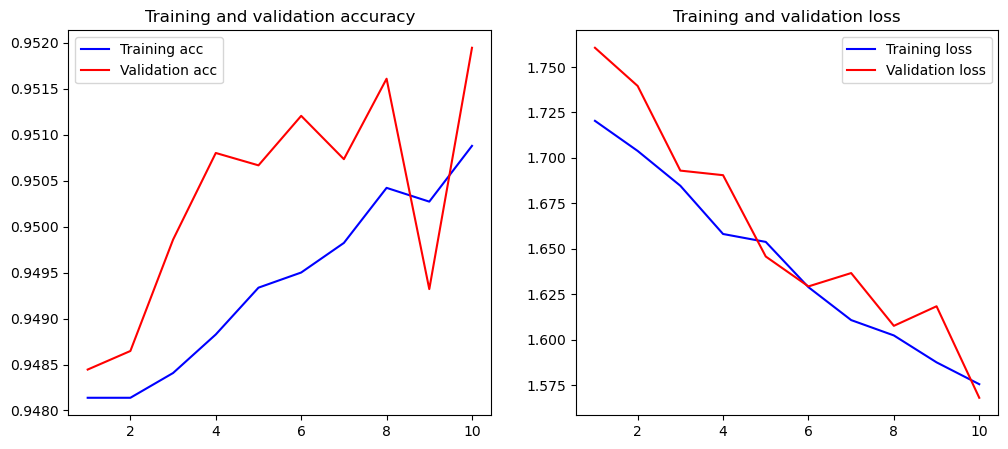

In [119]:
plot_history(history)

predictions = np.argmax(model_rnn3.predict(xpX_test), axis=-1)
print(predictions)

print(classification_report(y_test.values , predictions))
print('Precision is {}'.format(precision_score(y_test.values, predictions, average='macro')))
print("Poutsara mou kati kanoume twra sthn " , i  , "epanalispsi , thelei ligo parapanw sos")

Epoch 1/10
492/492 [==============================] - 44s 89ms/step - loss: 1.5647 - accuracy: 0.9512 - val_loss: 1.5624 - val_accuracy: 0.9519
Epoch 2/10
492/492 [==============================] - 44s 90ms/step - loss: 1.5663 - accuracy: 0.9511 - val_loss: 1.5674 - val_accuracy: 0.9530
Epoch 3/10
492/492 [==============================] - 44s 89ms/step - loss: 1.5416 - accuracy: 0.9517 - val_loss: 1.5870 - val_accuracy: 0.9519
Epoch 4/10
492/492 [==============================] - 44s 89ms/step - loss: 1.5305 - accuracy: 0.9517 - val_loss: 1.5752 - val_accuracy: 0.9527
Epoch 5/10
492/492 [==============================] - 43s 87ms/step - loss: 1.5217 - accuracy: 0.9519 - val_loss: 1.5295 - val_accuracy: 0.9530
Epoch 6/10
492/492 [==============================] - 47s 95ms/step - loss: 1.5100 - accuracy: 0.9523 - val_loss: 1.5534 - val_accuracy: 0.9527
Epoch 7/10
492/492 [==============================] - 46s 93ms/step - loss: 1.5069 - accuracy: 0.9524 - val_loss: 1.5140 - val_accuracy:

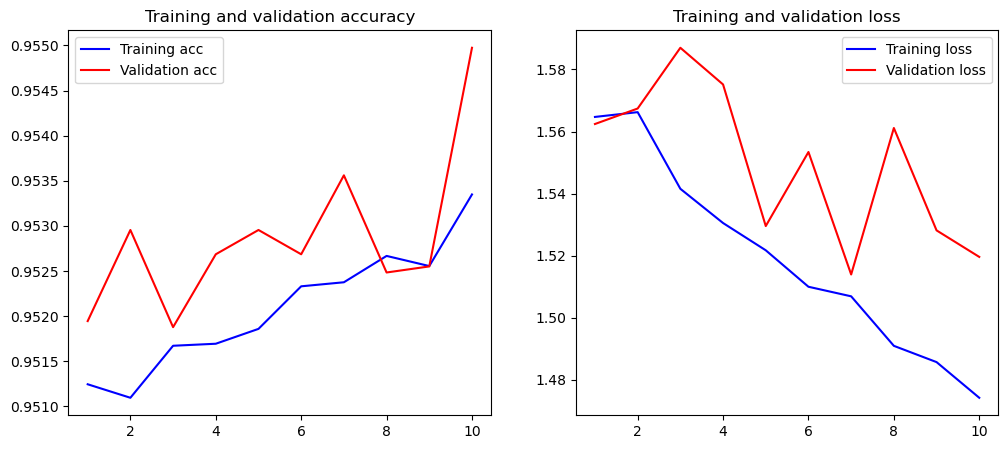

In [120]:
history = model_rnn3.fit(xpX_train, y_train1, batch_size = 16 ,epochs=10, validation_split=(0.1) ,verbose =1) # 40 epan

plot_history(history)

predictions = np.argmax(model_rnn3.predict(xpX_test), axis=-1)
print(predictions)

print(classification_report(y_test.values , predictions))
print('Precision is {}'.format(precision_score(y_test.values, predictions, average='macro')))
print("Poutsara mou kati kanoume twra sthn " , 40  , "h epanalispsi , thelei ligo parapanw sos")

Epoch 1/10
492/492 [==============================] - 43s 86ms/step - loss: 1.4660 - accuracy: 0.9532 - val_loss: 1.5422 - val_accuracy: 0.9540
Epoch 2/10
492/492 [==============================] - 46s 93ms/step - loss: 1.4562 - accuracy: 0.9535 - val_loss: 1.5916 - val_accuracy: 0.9534
Epoch 3/10
492/492 [==============================] - 42s 85ms/step - loss: 1.4555 - accuracy: 0.9537 - val_loss: 1.4765 - val_accuracy: 0.9546
Epoch 4/10
492/492 [==============================] - 43s 87ms/step - loss: 1.4510 - accuracy: 0.9539 - val_loss: 1.4995 - val_accuracy: 0.9536
Epoch 5/10
492/492 [==============================] - 42s 84ms/step - loss: 1.4331 - accuracy: 0.9539 - val_loss: 1.4810 - val_accuracy: 0.9540
Epoch 6/10
492/492 [==============================] - 42s 85ms/step - loss: 1.4310 - accuracy: 0.9544 - val_loss: 1.4830 - val_accuracy: 0.9554
Epoch 7/10
492/492 [==============================] - 46s 93ms/step - loss: 1.4198 - accuracy: 0.9543 - val_loss: 1.4811 - val_accuracy:

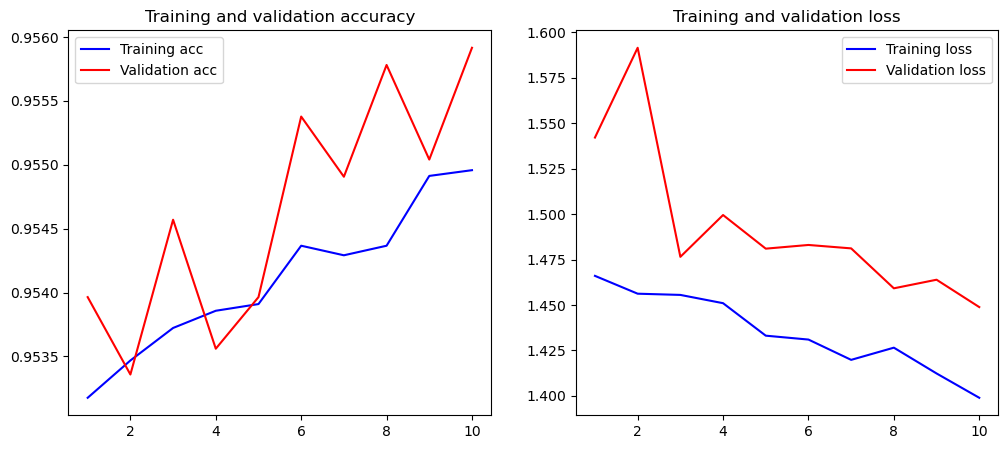

In [121]:
history = model_rnn3.fit(xpX_train, y_train1, batch_size = 16 ,epochs=10, validation_split=(0.1) ,verbose =1) # 50 epan

plot_history(history)

predictions = np.argmax(model_rnn3.predict(xpX_test), axis=-1)
print(predictions)

print(classification_report(y_test.values , predictions))
print('Precision is {}'.format(precision_score(y_test.values, predictions, average='macro')))
print("Poutsara mou kati kanoume twra sthn " , 50  , "h epanalispsi , thelei ligo parapanw sos")

Epoch 1/10
492/492 [==============================] - 44s 89ms/step - loss: 1.3960 - accuracy: 0.9550 - val_loss: 1.4720 - val_accuracy: 0.9550
Epoch 2/10
492/492 [==============================] - 44s 89ms/step - loss: 1.3907 - accuracy: 0.9551 - val_loss: 1.4504 - val_accuracy: 0.9552
Epoch 3/10
492/492 [==============================] - 44s 90ms/step - loss: 1.3784 - accuracy: 0.9553 - val_loss: 1.4426 - val_accuracy: 0.9556
Epoch 4/10
492/492 [==============================] - 45s 90ms/step - loss: 1.3725 - accuracy: 0.9553 - val_loss: 1.4471 - val_accuracy: 0.9563
Epoch 5/10
492/492 [==============================] - 44s 89ms/step - loss: 1.3633 - accuracy: 0.9555 - val_loss: 1.4551 - val_accuracy: 0.9550
Epoch 6/10
492/492 [==============================] - 41s 84ms/step - loss: 1.3621 - accuracy: 0.9557 - val_loss: 1.4379 - val_accuracy: 0.9565
Epoch 7/10
492/492 [==============================] - 41s 83ms/step - loss: 1.3568 - accuracy: 0.9555 - val_loss: 1.4203 - val_accuracy:

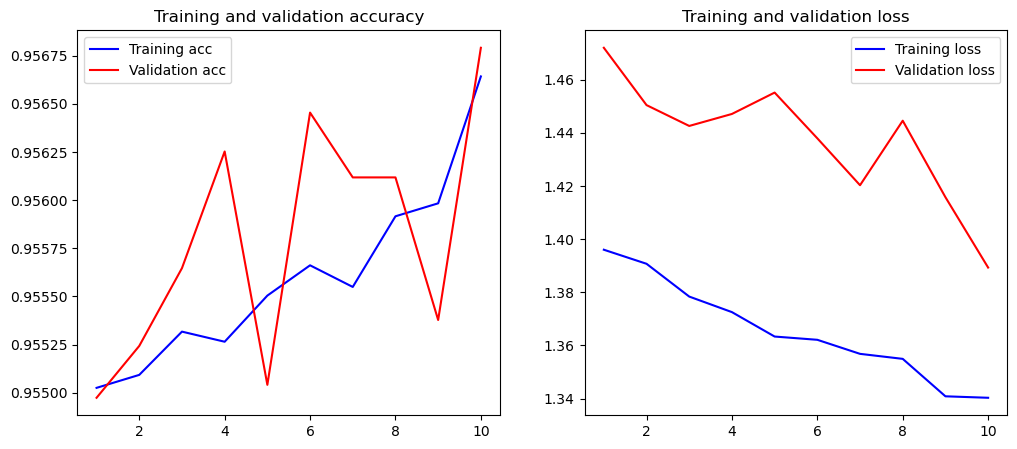

In [122]:
history = model_rnn3.fit(xpX_train, y_train1, batch_size = 16 ,epochs=10, validation_split=(0.1) ,verbose =1) # 60 epan

plot_history(history)

predictions = np.argmax(model_rnn3.predict(xpX_test), axis=-1)
print(predictions)

print(classification_report(y_test.values , predictions))
print('Precision is {}'.format(precision_score(y_test.values, predictions, average='macro')))
print("Poutsara mou kati kanoume twra sthn " , 60  , "h epanalispsi , thelei ligo parapanw sos")

Epoch 1/10
492/492 [==============================] - 41s 82ms/step - loss: 1.3219 - accuracy: 0.9568 - val_loss: 1.4239 - val_accuracy: 0.9560
Epoch 2/10
492/492 [==============================] - 43s 87ms/step - loss: 1.3236 - accuracy: 0.9568 - val_loss: 1.4507 - val_accuracy: 0.9564
Epoch 3/10
492/492 [==============================] - 44s 89ms/step - loss: 1.3285 - accuracy: 0.9562 - val_loss: 1.4850 - val_accuracy: 0.9563
Epoch 4/10
492/492 [==============================] - 41s 83ms/step - loss: 1.3129 - accuracy: 0.9569 - val_loss: 1.4278 - val_accuracy: 0.9569
Epoch 5/10
492/492 [==============================] - 39s 80ms/step - loss: 1.3108 - accuracy: 0.9571 - val_loss: 1.4167 - val_accuracy: 0.9569
Epoch 6/10
492/492 [==============================] - 41s 83ms/step - loss: 1.3085 - accuracy: 0.9565 - val_loss: 1.3919 - val_accuracy: 0.9577
Epoch 7/10
492/492 [==============================] - 41s 83ms/step - loss: 1.2989 - accuracy: 0.9574 - val_loss: 1.4337 - val_accuracy:

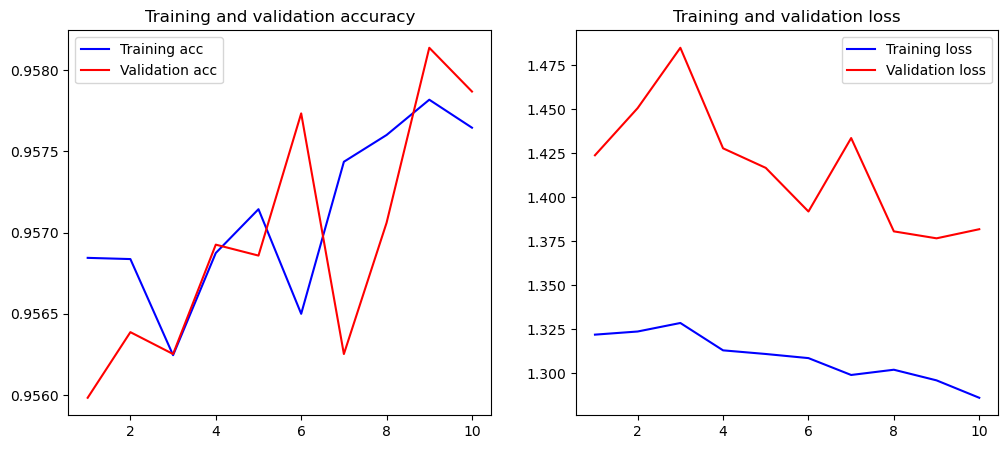

In [123]:
history = model_rnn3.fit(xpX_train, y_train1, batch_size = 16 ,epochs=10, validation_split=(0.1) ,verbose =1) # 60 epan

plot_history(history)

predictions = np.argmax(model_rnn3.predict(xpX_test), axis=-1)
print(predictions)

print(classification_report(y_test.values , predictions))
print('Precision is {}'.format(precision_score(y_test.values, predictions, average='macro')))
print("Poutsara mou kati kanoume twra sthn " , 60  , "h epanalispsi , thelei ligo parapanw sos")

# Model RNN 4 (BI- kati)

In [ ]:
model_rnn4 = Sequential()
model_rnn4.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True), input_shape=(xpX_train.shape[1], xpX_train.shape[2])))
model_rnn4.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)))
model_rnn4.add(tf.keras.layers.Dense(35,activation='relu'))
model_rnn4.add(tf.keras.layers.Dropout(0.2))
model_rnn4.add(tf.keras.layers.Dense(17,activation='softmax'))

In [137]:
model_rnn4.summary()

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_40 (Bidirect  (None, 200, 256)          133120    
 ional)                                                          
                                                                 
 bidirectional_41 (Bidirect  (None, 128)               164352    
 ional)                                                          
                                                                 
 dense_53 (Dense)            (None, 35)                4515      
                                                                 
 dropout_14 (Dropout)        (None, 35)                0         
                                                                 
 dense_54 (Dense)            (None, 17)                612       
                                                                 
Total params: 302599 (1.15 MB)
Trainable params: 3025

In [138]:
opt = tf.keras.optimizers.AdamW(learning_rate =0.0005 , beta_1=0.9,
    beta_2=0.999,
    use_ema=True,
    ema_momentum=0.99)

model_rnn4.compile(optimizer=opt, 
          loss = 'categorical_crossentropy',
          metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])

In [139]:
i = 0

Epoch 1/10
492/492 [==============================] - 88s 162ms/step - loss: 2.8002 - accuracy: 0.9412 - val_loss: 2.7804 - val_accuracy: 0.9412
Epoch 2/10
492/492 [==============================] - 70s 143ms/step - loss: 2.6964 - accuracy: 0.9414 - val_loss: 2.6290 - val_accuracy: 0.9412
Epoch 3/10
492/492 [==============================] - 72s 146ms/step - loss: 2.5763 - accuracy: 0.9421 - val_loss: 2.4553 - val_accuracy: 0.9427
Epoch 4/10
492/492 [==============================] - 67s 135ms/step - loss: 2.4398 - accuracy: 0.9426 - val_loss: 2.3197 - val_accuracy: 0.9434
Epoch 5/10
492/492 [==============================] - 66s 133ms/step - loss: 2.2707 - accuracy: 0.9431 - val_loss: 2.0802 - val_accuracy: 0.9437
Epoch 6/10
492/492 [==============================] - 70s 142ms/step - loss: 2.1954 - accuracy: 0.9432 - val_loss: 2.0995 - val_accuracy: 0.9438
Epoch 7/10
492/492 [==============================] - 69s 140ms/step - loss: 2.0842 - accuracy: 0.9437 - val_loss: 1.9968 - val_ac

C:\Users\Desktop\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Desktop\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Desktop\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Desktop\anaconda3\Lib\site-packages\skle

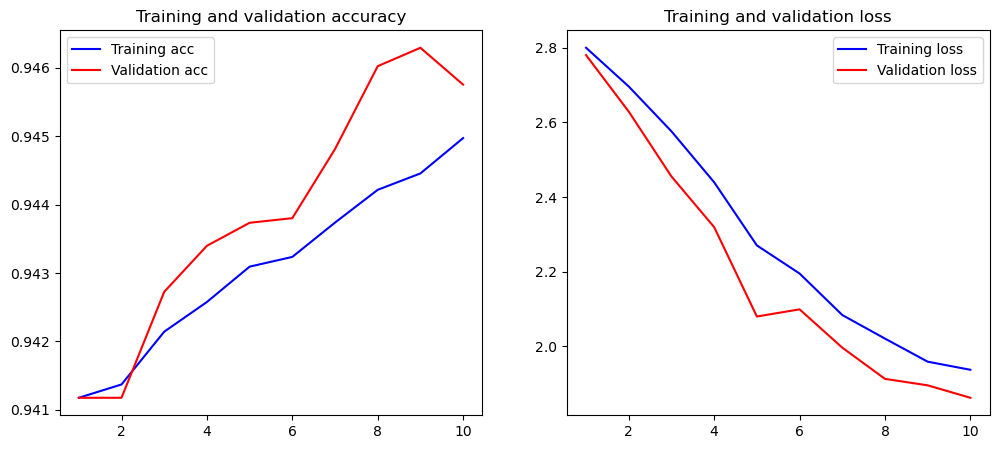

In [140]:
history = model_rnn4.fit(xpX_train, y_train1, batch_size = 16 ,epochs=10, validation_split=(0.1) ,verbose =1)
plot_history(history)
i+=10
predictions = np.argmax(model_rnn4.predict(xpX_test), axis=-1)
print(predictions)

print(classification_report(y_test.values , predictions))
print('Precision is {}'.format(precision_score(y_test.values, predictions, average='macro')))
print("Poutsara mou kati kanoume twra sthn " ,i  , "h epanalispsi , thelei ligo parapanw sos")

Epoch 1/10
492/492 [==============================] - 62s 126ms/step - loss: 1.8825 - accuracy: 0.9453 - val_loss: 1.8552 - val_accuracy: 0.9474
Epoch 2/10
492/492 [==============================] - 61s 125ms/step - loss: 1.8593 - accuracy: 0.9461 - val_loss: 1.7950 - val_accuracy: 0.9486
Epoch 3/10
492/492 [==============================] - 61s 124ms/step - loss: 1.8353 - accuracy: 0.9462 - val_loss: 1.7936 - val_accuracy: 0.9476
Epoch 4/10
492/492 [==============================] - 62s 127ms/step - loss: 1.7810 - accuracy: 0.9466 - val_loss: 1.8005 - val_accuracy: 0.9494
Epoch 5/10
492/492 [==============================] - 70s 143ms/step - loss: 1.7370 - accuracy: 0.9476 - val_loss: 1.7175 - val_accuracy: 0.9499
Epoch 6/10
492/492 [==============================] - 79s 160ms/step - loss: 1.6996 - accuracy: 0.9481 - val_loss: 1.6357 - val_accuracy: 0.9507
Epoch 7/10
492/492 [==============================] - 66s 134ms/step - loss: 1.6683 - accuracy: 0.9487 - val_loss: 1.6261 - val_ac

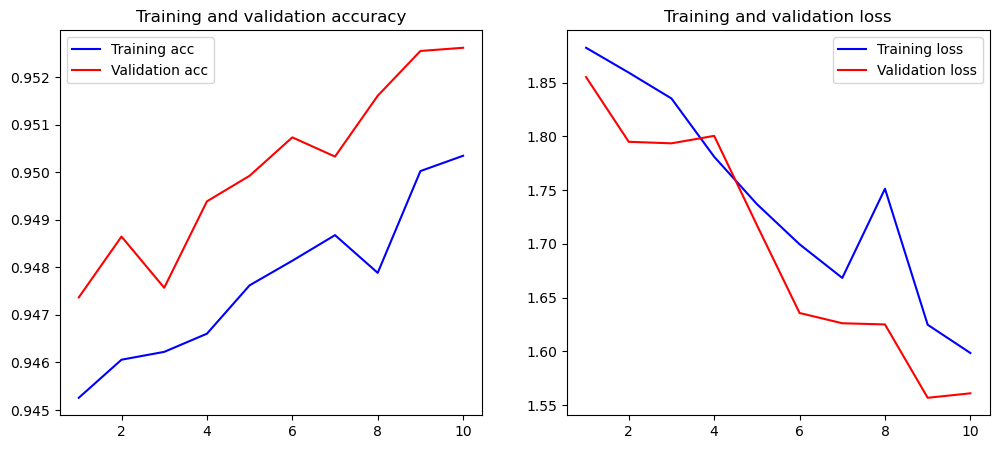

In [141]:
history = model_rnn4.fit(xpX_train, y_train1, batch_size = 16 ,epochs=10, validation_split=(0.1) ,verbose =1)
plot_history(history)
i+=10
predictions = np.argmax(model_rnn4.predict(xpX_test), axis=-1)
print(predictions)

print(classification_report(y_test.values , predictions))
print('Precision is {}'.format(precision_score(y_test.values, predictions, average='macro')))
print("Poutsara mou kati kanoume twra sthn " ,i  , "h epanalispsi , thelei ligo parapanw sos")

Epoch 1/10
492/492 [==============================] - 64s 129ms/step - loss: 1.5704 - accuracy: 0.9507 - val_loss: 1.5573 - val_accuracy: 0.9528
Epoch 2/10
492/492 [==============================] - 64s 131ms/step - loss: 1.5407 - accuracy: 0.9514 - val_loss: 1.4791 - val_accuracy: 0.9537
Epoch 3/10
492/492 [==============================] - 67s 135ms/step - loss: 1.5134 - accuracy: 0.9517 - val_loss: 1.5627 - val_accuracy: 0.9517
Epoch 4/10
492/492 [==============================] - 67s 137ms/step - loss: 1.4939 - accuracy: 0.9527 - val_loss: 1.5175 - val_accuracy: 0.9521
Epoch 5/10
492/492 [==============================] - 67s 137ms/step - loss: 1.4781 - accuracy: 0.9529 - val_loss: 1.4651 - val_accuracy: 0.9538
Epoch 6/10
492/492 [==============================] - 64s 130ms/step - loss: 1.4629 - accuracy: 0.9531 - val_loss: 1.4216 - val_accuracy: 0.9561
Epoch 7/10
492/492 [==============================] - 65s 132ms/step - loss: 1.4253 - accuracy: 0.9541 - val_loss: 1.4686 - val_ac

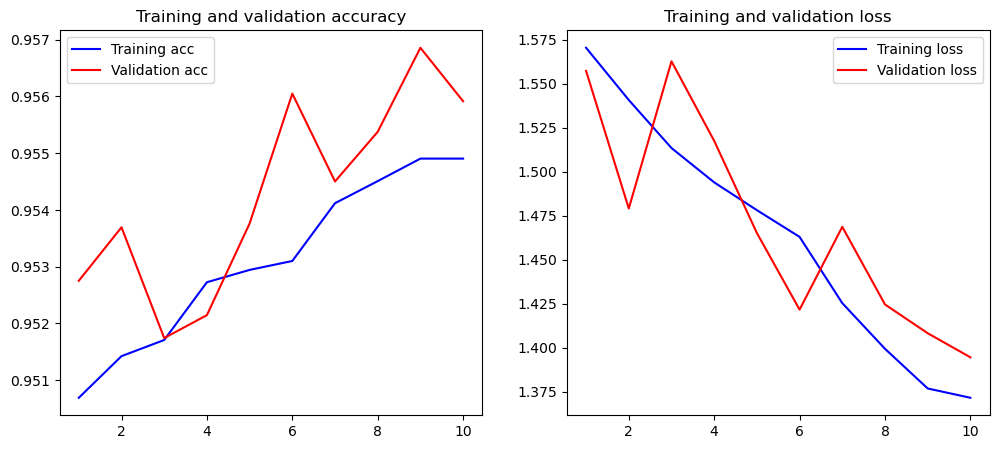

In [142]:
history = model_rnn4.fit(xpX_train, y_train1, batch_size = 16 ,epochs=10, validation_split=(0.1) ,verbose =1)
plot_history(history)
i+=10
predictions = np.argmax(model_rnn4.predict(xpX_test), axis=-1)
print(predictions)

print(classification_report(y_test.values , predictions))
print('Precision is {}'.format(precision_score(y_test.values, predictions, average='macro')))
print("Poutsara mou kati kanoume twra sthn " ,i  , "h epanalispsi , thelei ligo parapanw sos")

Epoch 1/10
492/492 [==============================] - 68s 138ms/step - loss: 1.3478 - accuracy: 0.9558 - val_loss: 1.4076 - val_accuracy: 0.9579
Epoch 2/10
492/492 [==============================] - 62s 126ms/step - loss: 1.3333 - accuracy: 0.9560 - val_loss: 1.3868 - val_accuracy: 0.9563
Epoch 3/10
492/492 [==============================] - 63s 129ms/step - loss: 1.3213 - accuracy: 0.9561 - val_loss: 1.3886 - val_accuracy: 0.9557
Epoch 4/10
492/492 [==============================] - 65s 132ms/step - loss: 1.3051 - accuracy: 0.9564 - val_loss: 1.3775 - val_accuracy: 0.9557
Epoch 5/10
492/492 [==============================] - 67s 137ms/step - loss: 1.2911 - accuracy: 0.9573 - val_loss: 1.3504 - val_accuracy: 0.9576
Epoch 6/10
492/492 [==============================] - 63s 128ms/step - loss: 1.2719 - accuracy: 0.9575 - val_loss: 1.3627 - val_accuracy: 0.9581
Epoch 7/10
492/492 [==============================] - 67s 137ms/step - loss: 1.2527 - accuracy: 0.9580 - val_loss: 1.3883 - val_ac

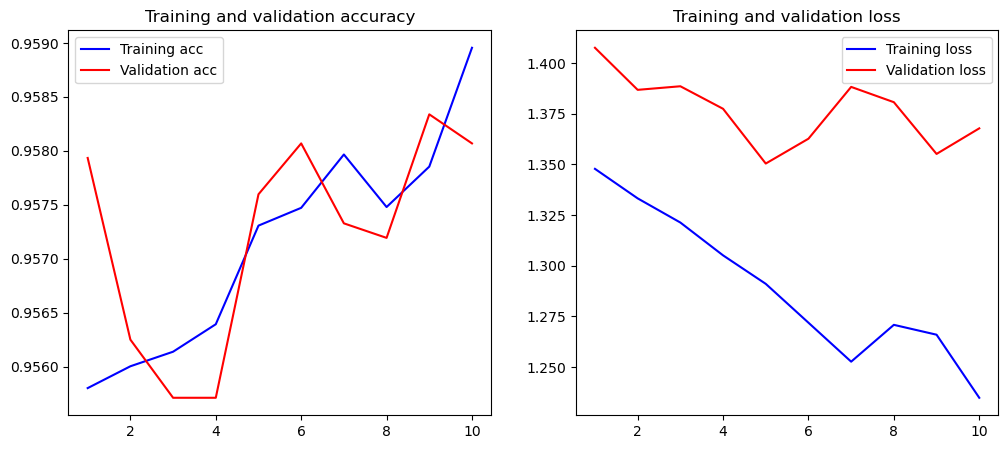

In [143]:
history = model_rnn4.fit(xpX_train, y_train1, batch_size = 16 ,epochs=10, validation_split=(0.1) ,verbose =1)
plot_history(history)
i+=10
predictions = np.argmax(model_rnn4.predict(xpX_test), axis=-1)
print(predictions)

print(classification_report(y_test.values , predictions))
print('Precision is {}'.format(precision_score(y_test.values, predictions, average='macro')))
print("Poutsara mou kati kanoume twra sthn " ,i  , "h epanalispsi , thelei ligo parapanw sos")

Epoch 1/10
492/492 [==============================] - 63s 128ms/step - loss: 1.2222 - accuracy: 0.9589 - val_loss: 1.3290 - val_accuracy: 0.9579
Epoch 2/10
492/492 [==============================] - 64s 131ms/step - loss: 1.2059 - accuracy: 0.9592 - val_loss: 1.3626 - val_accuracy: 0.9576
Epoch 3/10
492/492 [==============================] - 61s 124ms/step - loss: 1.1957 - accuracy: 0.9598 - val_loss: 1.3247 - val_accuracy: 0.9592
Epoch 4/10
492/492 [==============================] - 61s 123ms/step - loss: 1.1796 - accuracy: 0.9604 - val_loss: 1.3228 - val_accuracy: 0.9598
Epoch 5/10
492/492 [==============================] - 64s 130ms/step - loss: 1.1653 - accuracy: 0.9603 - val_loss: 1.3440 - val_accuracy: 0.9593
Epoch 6/10
492/492 [==============================] - 62s 125ms/step - loss: 1.1409 - accuracy: 0.9613 - val_loss: 1.3378 - val_accuracy: 0.9603
Epoch 7/10
492/492 [==============================] - 61s 125ms/step - loss: 1.1305 - accuracy: 0.9614 - val_loss: 1.3464 - val_ac

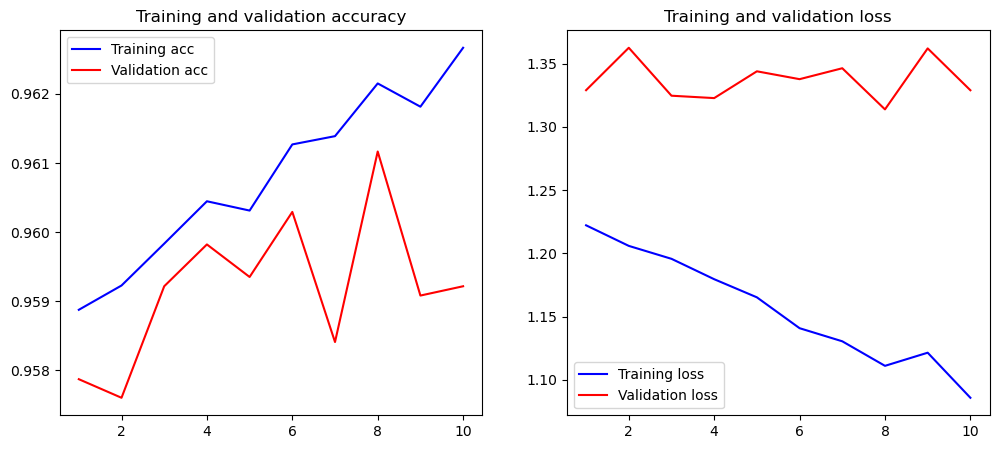

In [144]:
history = model_rnn4.fit(xpX_train, y_train1, batch_size = 16 ,epochs=10, validation_split=(0.1) ,verbose =1)
plot_history(history)
i+=10
predictions = np.argmax(model_rnn4.predict(xpX_test), axis=-1)
print(predictions)

print(classification_report(y_test.values , predictions))
print('Precision is {}'.format(precision_score(y_test.values, predictions, average='macro')))
print("Poutsara mou kati kanoume twra sthn " ,i  , "h epanalispsi , thelei ligo parapanw sos")

Epoch 1/10
492/492 [==============================] - 61s 124ms/step - loss: 1.0883 - accuracy: 0.9632 - val_loss: 1.3464 - val_accuracy: 0.9590
Epoch 2/10
492/492 [==============================] - 65s 132ms/step - loss: 1.0835 - accuracy: 0.9620 - val_loss: 1.3298 - val_accuracy: 0.9596
Epoch 3/10
492/492 [==============================] - 71s 143ms/step - loss: 1.0659 - accuracy: 0.9626 - val_loss: 1.3360 - val_accuracy: 0.9602
Epoch 4/10
492/492 [==============================] - 70s 142ms/step - loss: 1.0585 - accuracy: 0.9630 - val_loss: 1.3220 - val_accuracy: 0.9600
Epoch 5/10
492/492 [==============================] - 72s 147ms/step - loss: 1.0554 - accuracy: 0.9634 - val_loss: 1.3229 - val_accuracy: 0.9596
Epoch 6/10
492/492 [==============================] - 68s 139ms/step - loss: 1.0321 - accuracy: 0.9641 - val_loss: 1.3589 - val_accuracy: 0.9586
Epoch 7/10
492/492 [==============================] - 64s 131ms/step - loss: 1.0322 - accuracy: 0.9635 - val_loss: 1.3438 - val_ac

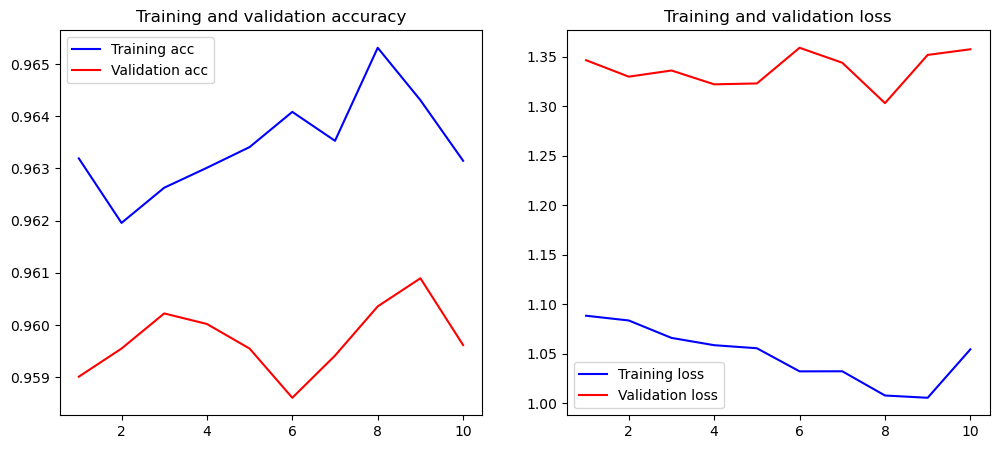

In [145]:
history = model_rnn4.fit(xpX_train, y_train1, batch_size = 16 ,epochs=10, validation_split=(0.1) ,verbose =1)
plot_history(history)
i+=10
predictions = np.argmax(model_rnn4.predict(xpX_test), axis=-1)
print(predictions)

print(classification_report(y_test.values , predictions))
print('Precision is {}'.format(precision_score(y_test.values, predictions, average='macro')))
print("Poutsara mou kati kanoume twra sthn " ,i  , "h epanalispsi , thelei ligo parapanw sos")

In [ ]:
history = model_rnn4.fit(xpX_train, y_train1, batch_size = 16 ,epochs=10, validation_split=(0.1) ,verbose =1)
plot_history(history)
i+=10
predictions = np.argmax(model_rnn4.predict(xpX_test), axis=-1)
print(predictions)

print(classification_report(y_test.values , predictions))
print('Precision is {}'.format(precision_score(y_test.values, predictions, average='macro')))
print("Poutsara mou kati kanoume twra sthn " ,i  , "h epanalispsi , thelei ligo parapanw sos")